In [3]:
import functools
from collections import OrderedDict
import dill

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

import scipy.interpolate

from hyperopt import fmin, tpe, Trials, hp

from timeit import default_timer

from qutip import basis, expect
from qutip.qip.operations import rx, rz

from qutip.operators import sigmax
from qutip.qip.operations import snot

from IPython.display import clear_output

from platform import python_version

import ipyparallel as ipp

# Local imports
from spectator_env_v2 import SpectatorEnvContinuousV2
from spectator_env_utils_v2 import extract_theta_phi, plot, plot_layered, get_error_unitary
from spectator_env_agent_v2 import ParallelSim

print(python_version())

%matplotlib inline
%load_ext autoreload
%autoreload 2

3.7.8
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


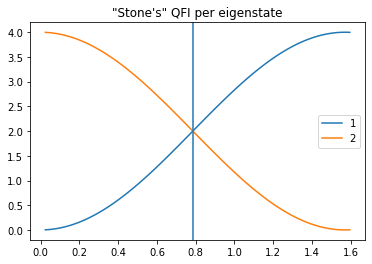

In [26]:
xs = np.linspace(np.pi / 128, np.pi / 2 + np.pi / 128, 100)
ys_1 = [
    ((np.cos(x + np.pi/4) ** 2 - np.cos(x - np.pi/4) ** 2) ** 2) / (np.cos(x) ** 2)
    for x in xs
    ]

ys_2 = [
    ((np.cos(x + np.pi/4 + np.pi / 2) ** 2 - np.cos(x - np.pi/4 + np.pi / 2) ** 2) ** 2) / (np.cos(x + np.pi / 2) ** 2)
    for x in xs
    ]

plt.figure()
plt.title("\"Stone's\" QFI per eigenstate")
plt.plot(xs, ys_1, label="1")
plt.plot(xs, ys_2, label="2")
plt.legend()
plt.axvline(np.pi / 4)
plt.show()

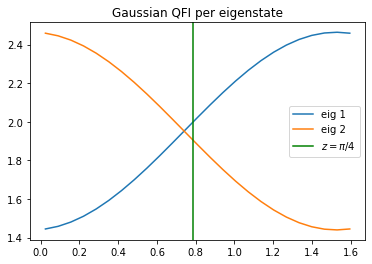

In [60]:
sigma = np.pi / 8
xs = np.linspace(np.pi / 128, np.pi / 2 + np.pi / 128, 25)
noise = np.random.normal(0, sigma, 1000)

ys_1 = []
ys_2 = []
for x in xs:
    ys_1.append(
        np.mean([
        n ** 2 * ((np.cos(x + n + np.pi/4) ** 2 - np.cos(x + n - np.pi/4) ** 2) ** 2) / (np.cos(x + n) ** 2)
        for n in noise
        ])
    )
    ys_2.append(
        np.mean([
        n ** 2 * ((np.cos(x + n + np.pi/4 + np.pi / 2) ** 2 - np.cos(x + n - np.pi/4 + np.pi / 2) ** 2) ** 2) / (np.cos(x + n + np.pi / 2) ** 2)
        for n in noise
        ])
    )
ys_1 = np.array(ys_1)
ys_2 = np.array(ys_2)

plt.figure()
plt.title("Gaussian QFI per eigenstate")
plt.plot(xs, ys_1 / (sigma ** 2), label="eig 1")
plt.plot(xs, ys_2 / (sigma ** 2), label="eig 2")
# plt.plot(xs, np.array(ys_1) + np.array(ys_2), label="sum")
plt.axvline(np.pi / 4, c='g', label=r'$z=\pi/4$')
plt.legend()
plt.show()

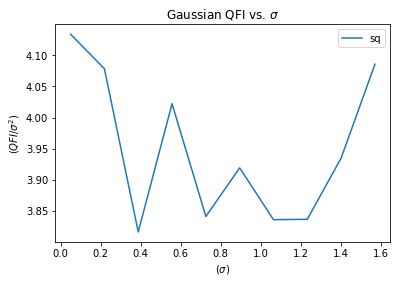

In [58]:
sigmas = np.linspace(np.pi/64, np.pi/2, 10)

ys = []
for s in sigmas:
    xs = np.linspace(np.pi / 128, np.pi / 2 + np.pi / 128, 25)
    noise = np.random.normal(0, s, 1000)
    tmp = []
    for x in xs:
        tmp.append(
            np.mean([
            n ** 2 * ((np.cos(x + n + np.pi/4) ** 2 - np.cos(x + n - np.pi/4) ** 2) ** 2) / (np.cos(x + n) ** 2)
            for n in noise
            ])
        +
            np.mean([
            n ** 2 * ((np.cos(x + n + np.pi/4 + np.pi / 2) ** 2 - np.cos(x + n - np.pi/4 + np.pi / 2) ** 2) ** 2) / (np.cos(x + n + np.pi / 2) ** 2)
            for n in noise
            ])
        )
    ys.append(np.mean(tmp))

plt.figure()
plt.title(r"Gaussian QFI vs. $\sigma$")
# plt.plot(sigmas, ys, label="sum")
# plt.plot(sigmas, ys / sigmas, label="n")
plt.plot(sigmas, ys / (sigmas ** 2), label="sq")
plt.xlabel(r"$(\sigma)$")
plt.ylabel(r"$(QFI / \sigma^2)$")
plt.legend()
plt.show()